## End-to-End

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None


### Taking a peek

In [12]:
# current_dir = './data/'

# files_lst = os.listdir(current_dir)
# files_lst

['file3.txt', 'file1.csv', 'file2.csv', 'file4.csv', '.ipynb_checkpoints']

In [19]:
df = pd.read_csv('file.csv')
# df = pd.DataFrame()

# for file in files_lst:
#     if file.endswith('1.csv'):
#         data = pd.read_csv(current_dir + file)
#         df = pd.concat([df, data])
        
# df = df.drop_duplicates()

In [20]:
df.head()

,CONTROLN,STATE,GENDER,HV1,IC1,IC4,HVP1,IC5,POBC1,POBC2,IC2,IC3,AVGGIFT,TCODE,DOB,DOMAIN,TARGET_D
0,44060,FL,M,AAA896,392,520.0,7,21975,6,16,430.0,466,28.000000,1,1901,C2,100.0
1,96093,IL,M,537.00,365,473.0,0,19387,1,89,415.0,410,5.666667,0,0,T2,7.0
2,43333,FL,F,725.00,301,436.0,3,18837,11,17,340.0,361,4.111111,0,2501,C2,5.0
3,21885,NC,M,AAA1095,401,413.0,7,14014,1,74,407.0,399,27.277778,0,2208,T2,38.0
4,190108,FL,F,995.00,252,348.0,0,17991,5,6,280.0,316,6.000000,28,0,C2,5.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CONTROLN  1000 non-null   int64  
 1   STATE     1000 non-null   object 
 2   GENDER    961 non-null    object 
 3   HV1       998 non-null    object 
 4   IC1       1000 non-null   int64  
 5   IC4       999 non-null    float64
 6   HVP1      1000 non-null   int64  
 7   IC5       1000 non-null   object 
 8   POBC1     1000 non-null   int64  
 9   POBC2     1000 non-null   int64  
 10  IC2       999 non-null    float64
 11  IC3       1000 non-null   int64  
 12  AVGGIFT   1000 non-null   float64
 13  TCODE     1000 non-null   int64  
 14  DOB       1000 non-null   int64  
 15  DOMAIN    1000 non-null   object 
 16  TARGET_D  1000 non-null   float64
dtypes: float64(4), int64(8), object(5)
memory usage: 140.6+ KB


### Data Cleaning

In [22]:
# first I like to standardize the columns
df.columns = [column.lower().replace(' ', '_') for column in df.columns]

In [23]:
# ControlN is the id, unique, so I passed it as the index
df = df.set_index('controln')

In [24]:
# from the .info above i can see that some numericals are considered as categoricals
# let's fix that first for hv1 and ic5
df1 = df.copy() # here i see i'll spend some runs to make this work, so better make a copy

df1['hv1'] = df1['hv1'].apply(lambda x: float(str(x).replace('AAA', '')))
df1['ic5'] = df1['ic5'].apply(lambda x: float(str(x).replace('@', '')))

In [25]:
# check my categories in each categorical column
cat = df1.select_dtypes('object')
cat

,state,gender,domain
controln,,,
44060,FL,M,C2
96093,IL,M,T2
43333,FL,F,C2
21885,NC,M,T2
190108,FL,F,C2
...,...,...,...
30104,GA,M,R2
154614,CA,F,T1
57151,KY,F,R1


In [26]:
# I see that some need parametrization (making it all with standard values)
for column in cat.columns:
    print(column, cat[column].unique())

state ['FL' 'IL' 'NC' 'TX' 'CA' 'NV' 'Cali' 'AP' 'KS' 'MI' 'OK' 'AR' 'IN' 'MT'
 'WI' 'MO' 'HI' 'UT' 'GA' 'WA' 'ID' 'CT' 'AL' 'ND' 'SC' 'IA' 'CO' 'LA'
 'OR' 'SD' 'TN' 'NM' 'AZ' 'MN' 'KY' 'NJ' 'NE' 'California' 'MS' 'NY'
 'Arizona' 'WY' 'Tennessee']
gender ['M' 'F' 'female' 'Male' nan 'U' 'J' 'male' 'Female' 'feamale']
domain ['C2' 'T2' 'S2' 'R2' 'C1' 'S1' 'T1' 'U1' '0' 'C3' 'S3' 'R3' 'R1' 'U3' 'U4'
 'U2' 'T3']


In [ ]:
def clean_gender(x):
    if str(x).lower().startswith('m'):
        return 'M'
    elif str(x).lower().startswith('f'):
        return 'F'
    else:
        return 'O'

df1['gender'] = df1['gender'].apply(clean_gender)

In [28]:
df1['gender'] = df1['gender'].apply(lambda x: 'M' if str(x).lower().startswith('m')
                                                  else 'F' if str(x).lower().startswith('f')
                                                  else 'O')
df1['gender'] = df1['gender'].fillna('O')

df1.gender.value_counts()

F    511
M    419
O     70
Name: gender, dtype: int64

In [29]:
df1['state'] = df1['state'].apply(lambda x: 'CA' if str(x).lower().startswith('cali')
                                                 else 'TN' if x == 'Tennessee'
                                                 else 'AZ' if x == 'Arizona'
                                                 else x)
df1.state.value_counts()

CA    228
FL     86
TX     75
IL     66
MI     51
NC     42
WA     35
GA     33
IN     31
WI     30
MO     25
MN     22
OR     22
TN     21
AZ     21
CO     19
SC     19
OK     17
AL     17
LA     15
KY     15
IA     15
NV     10
KS     10
ID      9
NE      9
AR      9
NM      7
MS      7
SD      7
UT      5
HI      5
MT      5
ND      4
WY      3
CT      2
NY      1
AP      1
NJ      1
Name: state, dtype: int64

In [30]:
## Extra: i'd check if i could bucket 'domain' only in it's main categories (U,T,S,R)
df1.domain.value_counts()

T2    134
S1    133
R2    113
C2    101
S2     91
C1     74
U1     60
T1     55
R3     54
C3     52
0      27
U3     25
U2     24
T3     16
R1     15
S3     15
U4     11
Name: domain, dtype: int64

In [31]:
df1.isna().sum()

state       0
gender      0
hv1         2
ic1         0
ic4         1
hvp1        0
ic5         0
pobc1       0
pobc2       0
ic2         1
ic3         0
avggift     0
tcode       0
dob         0
domain      0
target_d    0
dtype: int64

In [ ]:
for val in df.gender.unique():
    mean_val = df[df['gender'] == val, 'hv1'].mean()
    df[df['gender'] == val, 'hv1'] = df[df['gender'] == val, 'hv1'].fillna(mean_val)

In [32]:
df = df1.dropna() #  to avoid having to remember in which copy number I'm at
df

,state,gender,hv1,ic1,ic4,hvp1,ic5,pobc1,pobc2,ic2,ic3,avggift,tcode,dob,domain,target_d
controln,,,,,,,,,,,,,,,,
44060,FL,M,896.0,392,520.0,7,21975.0,6,16,430.0,466,28.000000,1,1901,C2,100.0
96093,IL,M,537.0,365,473.0,0,19387.0,1,89,415.0,410,5.666667,0,0,T2,7.0
43333,FL,F,725.0,301,436.0,3,18837.0,11,17,340.0,361,4.111111,0,2501,C2,5.0
21885,NC,M,1095.0,401,413.0,7,14014.0,1,74,407.0,399,27.277778,0,2208,T2,38.0
190108,FL,F,995.0,252,348.0,0,17991.0,5,6,280.0,316,6.000000,28,0,C2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30104,GA,M,364.0,246,325.0,0,9720.0,0,89,307.0,287,8.833333,1,5201,R2,15.0
154614,CA,F,1709.0,511,537.0,26,15138.0,9,68,518.0,527,15.000000,0,0,T1,20.0
57151,KY,F,875.0,311,326.0,0,7746.0,3,29,326.0,326,15.900000,0,3601,R1,26.0


### EDA

In [33]:
df.describe().apply(lambda x: round(x,2)) # a lambda just to round it pretty

,hv1,ic1,ic4,hvp1,ic5,pobc1,pobc2,ic2,ic3,avggift,tcode,dob,target_d
count,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.00
mean,1182.39,351.47,444.50,16.23,16596.40,6.82,55.63,401.29,399.44,11.88,38.10,2550.63,16.05
std,1078.80,173.50,177.39,29.44,10280.71,9.30,21.61,181.25,168.29,7.86,214.16,2071.34,14.66
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.36,0.00,0.00,1.00
25%,537.75,238.00,325.00,0.00,10975.75,1.00,40.75,283.00,286.00,7.29,0.00,0.00,10.00
50%,786.50,319.00,405.00,1.00,14193.50,4.00,57.00,364.00,360.00,10.00,1.00,2501.00,14.00
75%,1409.75,420.25,526.25,14.00,18817.25,9.00,74.00,474.25,477.25,14.51,2.00,4307.00,20.00
max,5980.00,1500.00,1263.00,99.00,174523.00,73.00,96.00,1500.00,1185.00,89.44,4002.00,8305.00,200.00


In [34]:
df.select_dtypes(np.number)

,hv1,ic1,ic4,hvp1,ic5,pobc1,pobc2,ic2,ic3,avggift,tcode,dob,target_d
controln,,,,,,,,,,,,,
44060,896.0,392,520.0,7,21975.0,6,16,430.0,466,28.000000,1,1901,100.0
96093,537.0,365,473.0,0,19387.0,1,89,415.0,410,5.666667,0,0,7.0
43333,725.0,301,436.0,3,18837.0,11,17,340.0,361,4.111111,0,2501,5.0
21885,1095.0,401,413.0,7,14014.0,1,74,407.0,399,27.277778,0,2208,38.0
190108,995.0,252,348.0,0,17991.0,5,6,280.0,316,6.000000,28,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30104,364.0,246,325.0,0,9720.0,0,89,307.0,287,8.833333,1,5201,15.0
154614,1709.0,511,537.0,26,15138.0,9,68,518.0,527,15.000000,0,0,20.0
57151,875.0,311,326.0,0,7746.0,3,29,326.0,326,15.900000,0,3601,26.0


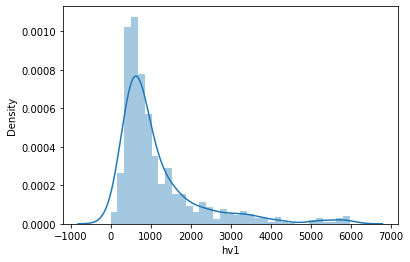

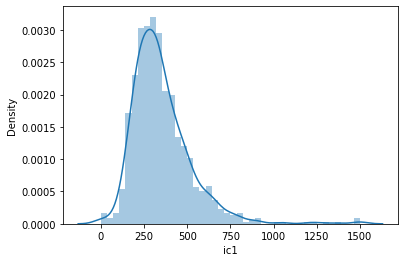

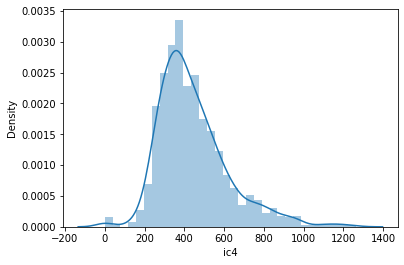

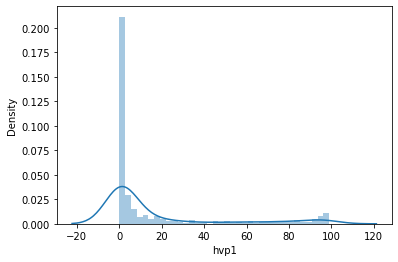

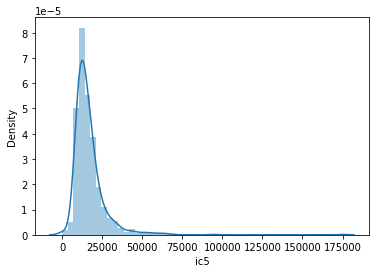

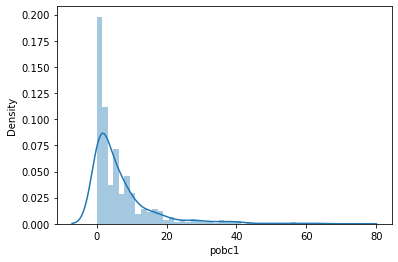

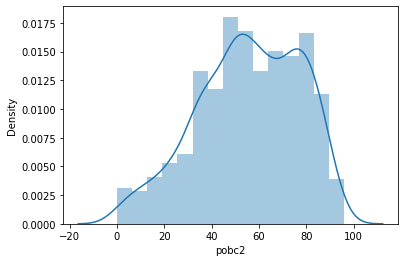

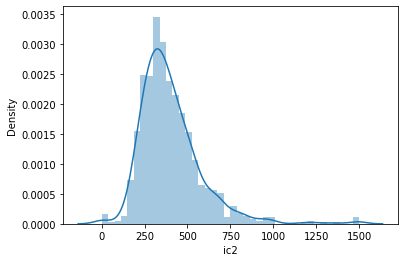

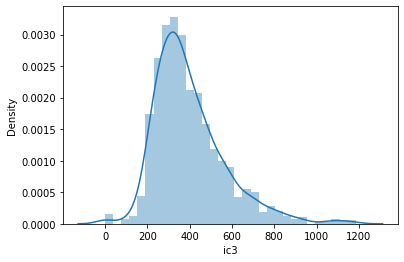

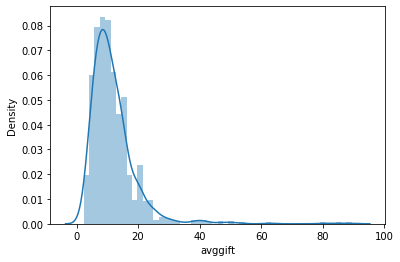

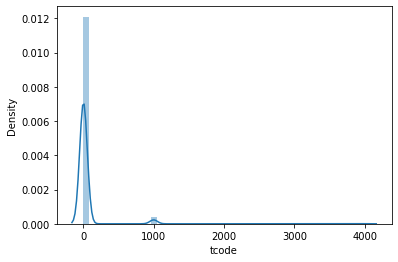

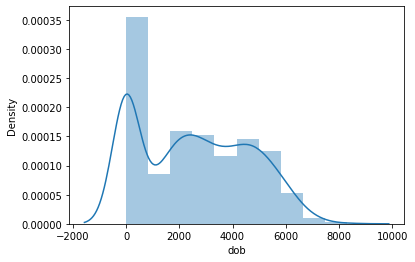

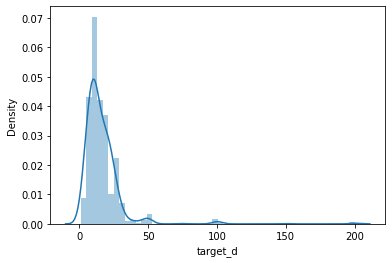

In [18]:
for column in df.select_dtypes(np.number).columns:
    sns.distplot(df[column])
    plt.show()

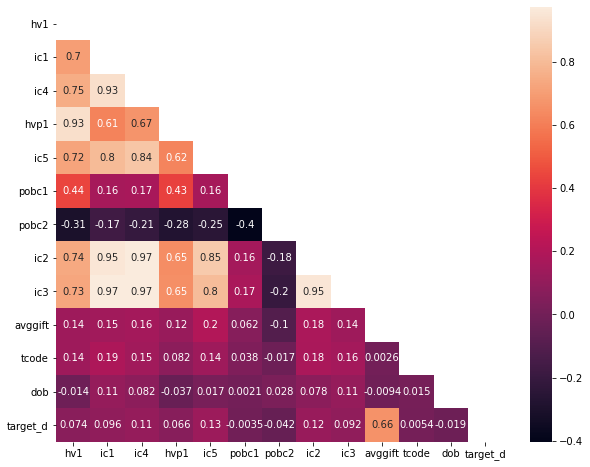

In [35]:
# check the correlations
mask = np.zeros_like(df.corr())

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df.corr(), mask=mask, annot=True)
plt.show()

# from this you can remove multicolinearity > 0.9 with no worry...
## ... > 0.75 is better to check with the model metrics to be sure
### when removing, keep the ones that have the highest correlation with target

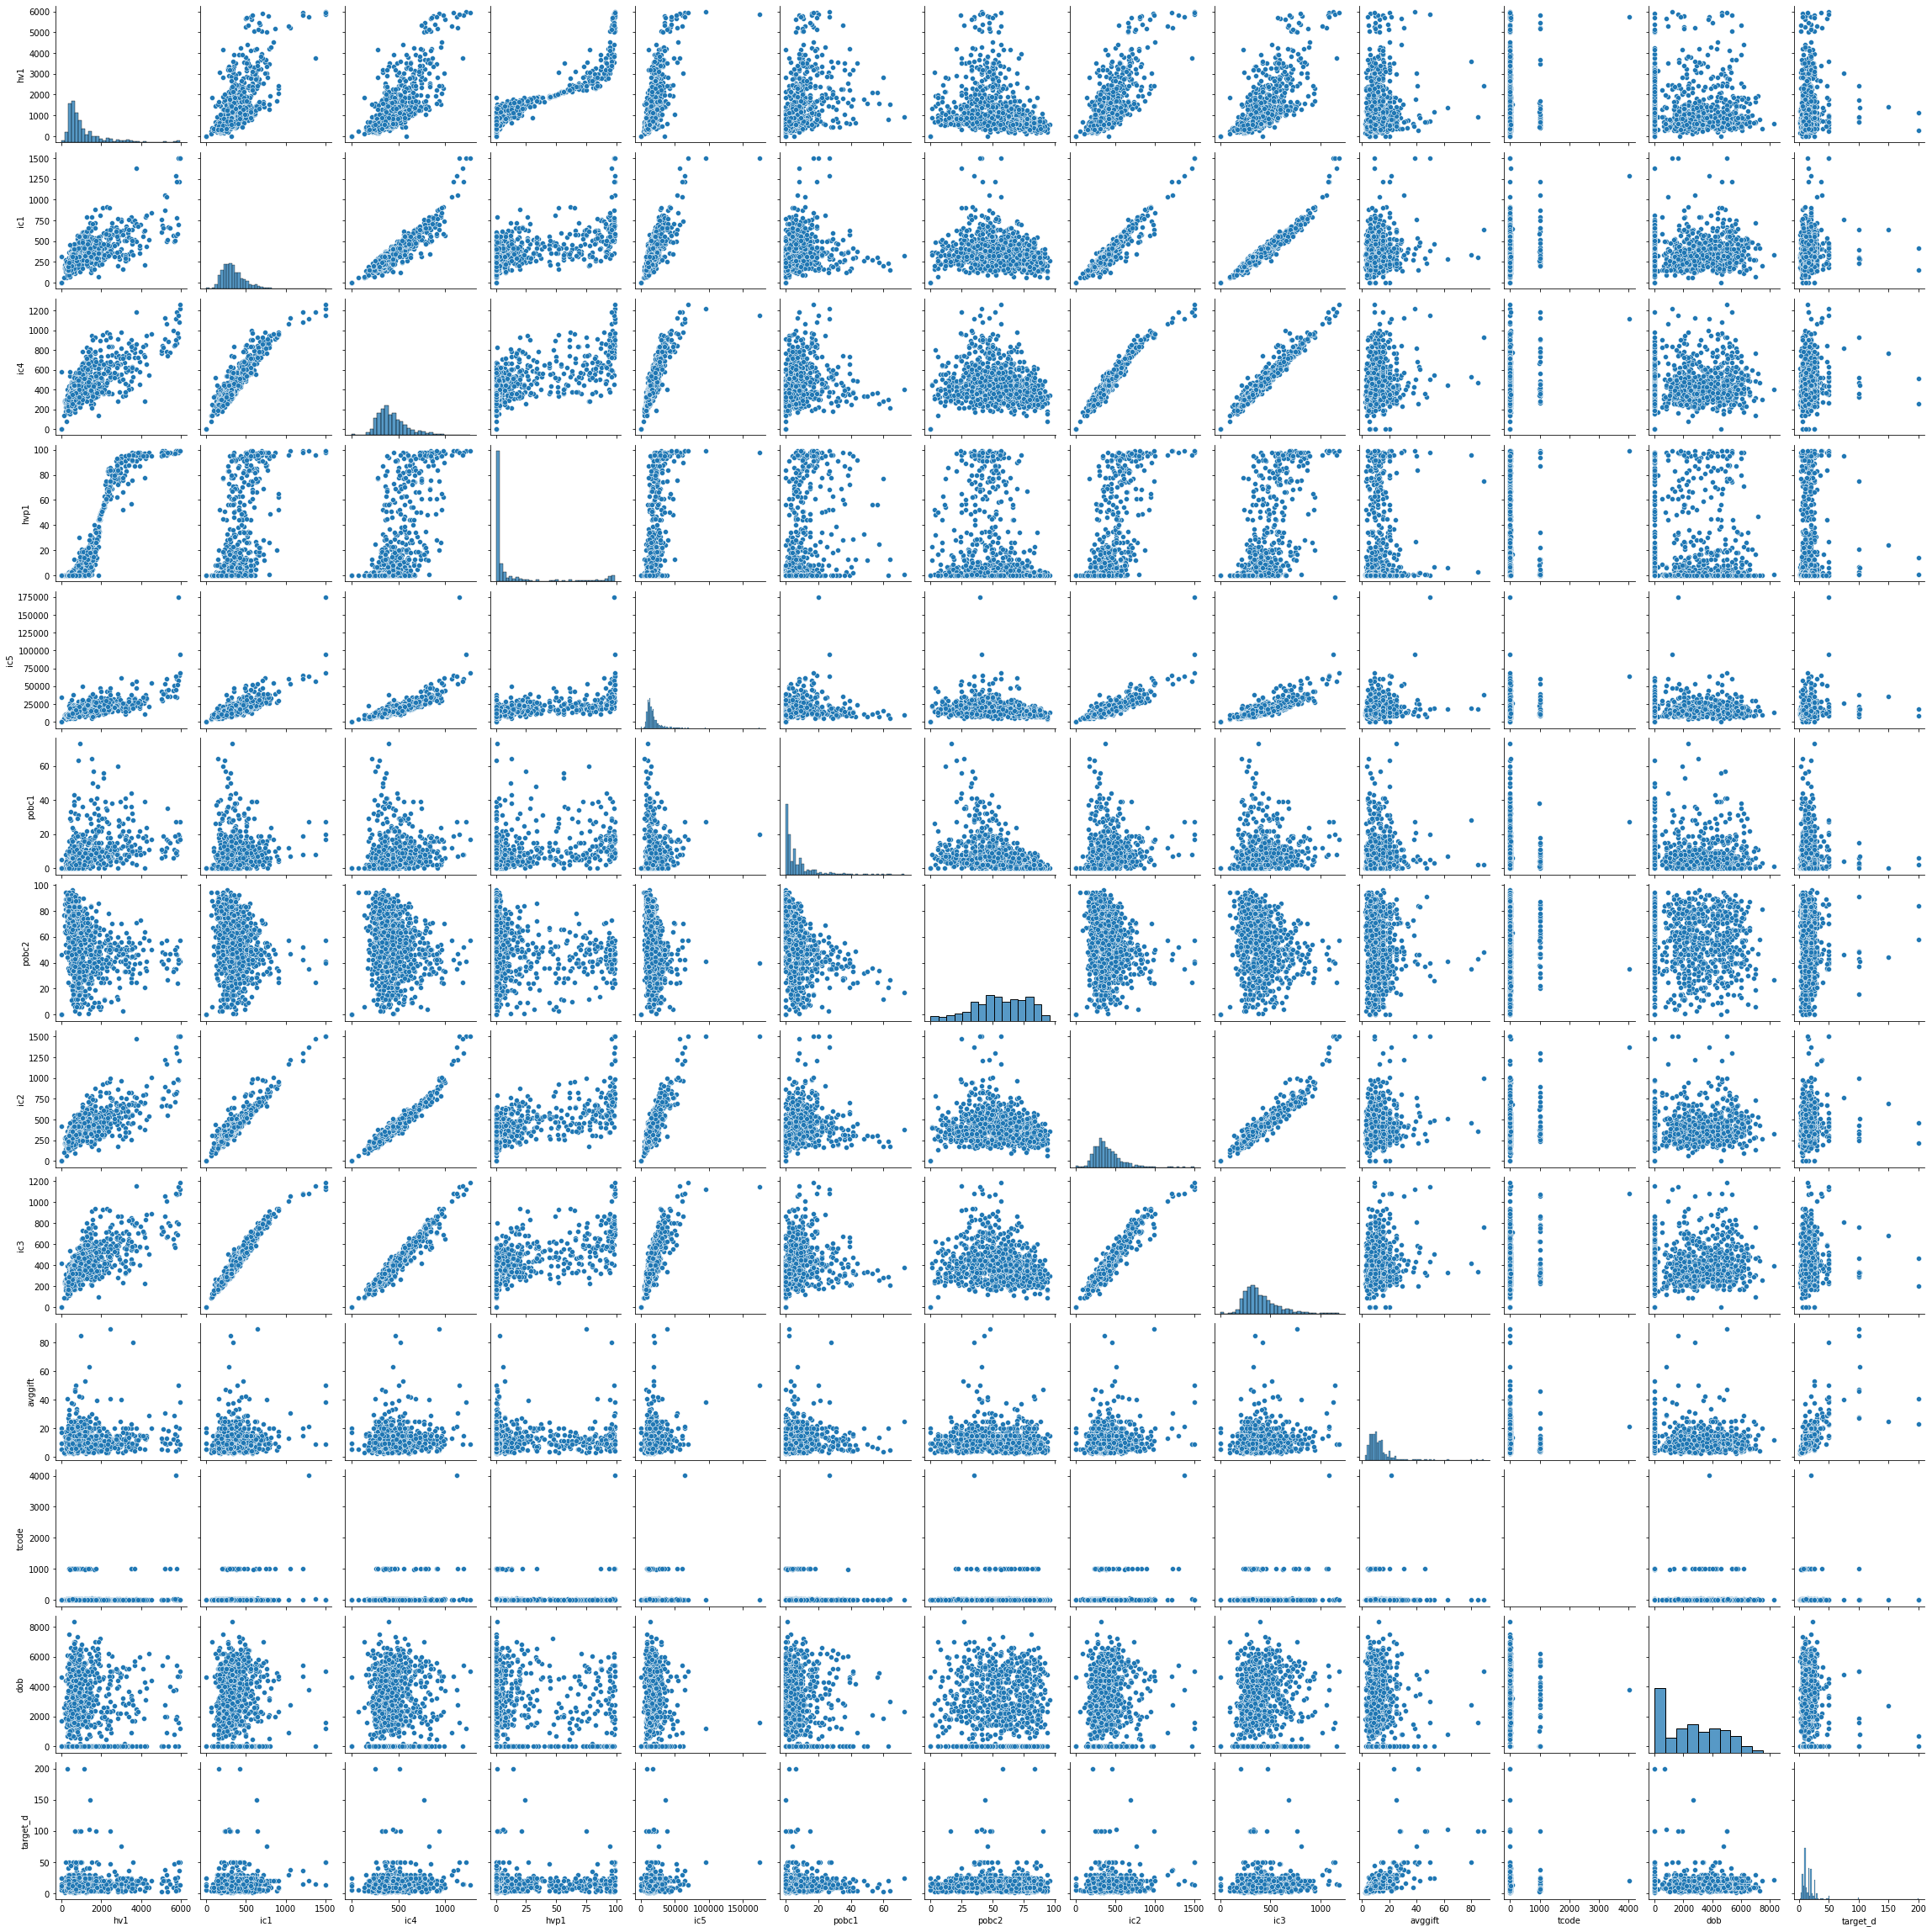

In [36]:
# covariance visualization
sns.pairplot(df)

### Feature Engineering

In [37]:
# In the first run, I prefer not to have any scaling, just to have a benchmark on my metrics
# then i come back to these steps and check different scaling techniques to see which is better

# usually you'll choose one scaling technique for the whole dataframe

# if you are going for StandardScaler, MinMaxScaler or Normalizer, remember to do it after the splits:
## X-y split for Normalizer;
## train-test split for the other two

# for this example i chose BoxCox transformation

def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

In [38]:
df, _ci = boxcox_transform(df)
df

,state,gender,hv1,ic1,ic4,hvp1,ic5,pobc1,pobc2,ic2,ic3,avggift,tcode,dob,domain,target_d
controln,,,,,,,,,,,,,,,,
44060,FL,M,2.862697,5.864851,4.642617,2.677767,2.233368,1.881132,20.243987,4.546258,4.637571,2.521271,0.000000,621.654768,C2,4.241186
96093,IL,M,2.793268,5.796000,4.591853,5.831579,2.231822,0.000000,151.211376,4.526866,4.566285,1.494890,4.416686,1036.408459,T2,1.878841
43333,FL,F,2.835287,5.609854,4.547818,1.310656,2.231455,2.559749,21.769331,4.416711,4.494540,1.251586,4.416686,780.279695,C2,1.563373
21885,NC,M,2.887071,5.886745,4.518319,2.677767,2.227395,0.000000,122.112978,4.516205,4.551029,2.506699,4.416686,703.754052,T2,3.407880
190108,FL,F,2.875619,5.438102,4.424044,5.831579,2.230858,1.681308,5.960955,4.307285,4.418546,1.536803,3.433758,1036.408459,C2,1.563373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30104,GA,M,2.732780,5.414794,4.385945,5.831579,2.221580,2.216875,151.211376,4.359434,4.362991,1.809604,0.000000,1430.673437,R2,2.579330
154614,CA,F,2.936116,6.120362,4.659745,5.656308,2.228506,2.332623,110.711290,4.646826,4.705242,2.154219,4.416686,1036.408459,T1,2.838749
57151,KY,F,2.859714,5.641426,4.387662,5.831579,2.217468,1.131790,40.984352,4.393193,4.436417,2.190217,4.416686,1055.255685,R1,3.072989


In [39]:
_ci

{'hv1': [-0.3055556571948782],
 'ic1': [-0.006040743706373128],
 'ic4': [-0.10052367838957699],
 'hvp1': [0.3123550438617344],
 'ic5': [-0.4423807172202932],
 'pobc1': [0.05389884192423716],
 'pobc2': [1.1506188844973486],
 'ic2': [-0.10004197015936432],
 'ic3': [-0.09630640373784101],
 'avggift': [-0.17595146795438374],
 'tcode': [0.017929495807796913],
 'dob': [0.8270655201322397],
 'target_d': [-0.036262882971037004]}

In [40]:
# you can decide to remove outliers after log / boxcox transformation
## (since these might take care of some outliers for you)

# make sure you are droping the outliers only after the feature selection,
# just so you don't end up losing rows because of outliers in a column you won't use

def remove_outliers(df, threshold=1.5, in_columns=df.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(df[column],75)
            lower = np.percentile(df[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df

In [42]:
df1 = df.copy()

df1 = remove_outliers(df1, threshold=1.5, skip_columns=['ic1']) # we don't want to reduce our data too much,
## but we can play with the parameters to see,
## so after a better analysis we can choose which columns to drop outliers or not
df1

,state,gender,hv1,ic1,ic4,hvp1,ic5,pobc1,pobc2,ic2,ic3,avggift,tcode,dob,domain,target_d
controln,,,,,,,,,,,,,,,,
96093,IL,M,2.793268,5.796000,4.591853,5.831579,2.231822,0.000000,151.211376,4.526866,4.566285,1.494890,4.416686,1036.408459,T2,1.878841
21885,NC,M,2.887071,5.886745,4.518319,2.677767,2.227395,0.000000,122.112978,4.516205,4.551029,2.506699,4.416686,703.754052,T2,3.407880
18581,NC,F,2.844111,5.662925,4.526186,2.091227,2.226833,2.216875,120.202695,4.454652,4.523559,1.342486,4.416686,1247.338643,R2,2.376238
119038,TX,M,2.861854,6.135321,4.681992,5.831579,2.230771,0.706258,70.296330,4.654004,4.729544,1.557726,7.356009,1036.408459,C1,1.878841
154301,CA,F,2.879324,6.016977,4.617357,0.000000,2.227172,2.658998,81.078147,4.594535,4.666417,1.970981,0.697472,857.041067,T2,2.209075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30104,GA,M,2.732780,5.414794,4.385945,5.831579,2.221580,2.216875,151.211376,4.359434,4.362991,1.809604,0.000000,1430.673437,R2,2.579330
154614,CA,F,2.936116,6.120362,4.659745,5.656308,2.228506,2.332623,110.711290,4.646826,4.705242,2.154219,4.416686,1036.408459,T1,2.838749
57151,KY,F,2.859714,5.641426,4.387662,5.831579,2.217468,1.131790,40.984352,4.393193,4.436417,2.190217,4.416686,1055.255685,R1,3.072989


In [43]:
df2 = remove_outliers(df1, threshold=1.5, in_columns=['target_d', 'avggift'])
# now filter the outliers on the more important columns with a tighter threshold
df2

,state,gender,hv1,ic1,ic4,hvp1,ic5,pobc1,pobc2,ic2,ic3,avggift,tcode,dob,domain,target_d
controln,,,,,,,,,,,,,,,,
96093,IL,M,2.793268,5.796000,4.591853,5.831579,2.231822,0.000000,151.211376,4.526866,4.566285,1.494890,4.416686,1036.408459,T2,1.878841
21885,NC,M,2.887071,5.886745,4.518319,2.677767,2.227395,0.000000,122.112978,4.516205,4.551029,2.506699,4.416686,703.754052,T2,3.407880
18581,NC,F,2.844111,5.662925,4.526186,2.091227,2.226833,2.216875,120.202695,4.454652,4.523559,1.342486,4.416686,1247.338643,R2,2.376238
119038,TX,M,2.861854,6.135321,4.681992,5.831579,2.230771,0.706258,70.296330,4.654004,4.729544,1.557726,7.356009,1036.408459,C1,1.878841
154301,CA,F,2.879324,6.016977,4.617357,0.000000,2.227172,2.658998,81.078147,4.594535,4.666417,1.970981,0.697472,857.041067,T2,2.209075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30104,GA,M,2.732780,5.414794,4.385945,5.831579,2.221580,2.216875,151.211376,4.359434,4.362991,1.809604,0.000000,1430.673437,R2,2.579330
154614,CA,F,2.936116,6.120362,4.659745,5.656308,2.228506,2.332623,110.711290,4.646826,4.705242,2.154219,4.416686,1036.408459,T1,2.838749
57151,KY,F,2.859714,5.641426,4.387662,5.831579,2.217468,1.131790,40.984352,4.393193,4.436417,2.190217,4.416686,1055.255685,R1,3.072989


In [44]:
# encoding categorical

# if we are talking about a more product-focused script, remember to use OneHotEncoding instead
# so you can save your fitted object

df = pd.get_dummies(df2, drop_first=True) # i'm lazy
df

,hv1,ic1,ic4,hvp1,ic5,pobc1,pobc2,ic2,ic3,avggift,tcode,dob,target_d,state_AP,state_AR,state_AZ,state_CA,state_CO,state_CT,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NJ,state_NM,state_NV,state_OK,state_OR,state_SC,state_SD,state_TN,state_TX,state_UT,state_WA,state_WI,state_WY,gender_M,gender_O,domain_C1,domain_C2,domain_C3,domain_R1,domain_R2,domain_R3,domain_S1,domain_S2,domain_S3,domain_T1,domain_T2,domain_T3,domain_U1,domain_U2,domain_U3,domain_U4
controln,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
96093,2.793268,5.796000,4.591853,5.831579,2.231822,0.000000,151.211376,4.526866,4.566285,1.494890,4.416686,1036.408459,1.878841,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
21885,2.887071,5.886745,4.518319,2.677767,2.227395,0.000000,122.112978,4.516205,4.551029,2.506699,4.416686,703.754052,3.407880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
18581,2.844111,5.662925,4.526186,2.091227,2.226833,2.216875,120.202695,4.454652,4.523559,1.342486,4.416686,1247.338643,2.376238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
119038,2.861854,6.135321,4.681992,5.831579,2.230771,0.706258,70.296330,4.654004,4.729544,1.557726,7.356009,1036.408459,1.878841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
154301,2.879324,6.016977,4.617357,0.000000,2.227172,2.658998,81.078147,4.594535,4.666417,1.970981,0.697472,857.041067,2.209075,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30104,2.732780,5.414794,4.385945,5.831579,2.221580,2.216875,151.211376,4.359434,4.362991,1.809604,0.000000,1430.673437,2.579330,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
154614,2.936116,6.120362,4.659745,5.656308,2.228506,2.332623,110.711290,4.646826,4.705242,2.154219,4.416686,1036.408459,2.838749,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
57151,2.859714,5.641426,4.387662,5.831579,2.217468,1.131790,40.984352,4.393193,4.436417,2.190217,4.416686,1055.255685,3.072989,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# splitting our data

X = df.drop('target_d', axis=1)
y = df['target_d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [47]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Analyzing Results

In [48]:
predictions = model.predict(X_test)

In [49]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.3244315917323889, 0.2549268200085205, 0.3172319803984794)

In [50]:
model.coef_

array([ 8.68987727e-02, -2.66244037e-01, -5.09952483e-01,  5.65681210e-04,
       -2.03391990e+00,  3.56931308e-02,  3.82643934e-05,  5.27767567e-01,
        7.74729480e-01,  1.00133355e+00,  7.87824762e-03, -2.56830644e-05,
       -2.98521513e-01,  2.31812271e-01,  2.08286541e-01,  6.80712801e-02,
        2.14177893e-01,  5.34730864e-01,  9.86585375e-02,  3.46780159e-01,
        3.42617975e-02,  2.06730655e-01,  2.86668440e-01,  2.22067803e-01,
        1.66106637e-01,  2.79243564e-01,  1.90017763e-01,  1.35144281e-01,
        2.08503817e-01,  1.16885529e-01,  3.34555328e-01,  2.34021538e-01,
        2.57577949e-01,  1.55432522e-01,  1.73184981e-01, -8.51379932e-02,
       -2.10961122e-01,  1.70577722e-01,  1.46846364e-01,  2.51013701e-01,
        2.41836848e-01,  1.62871147e-01,  6.01517064e-01,  2.64563364e-01,
        1.33909668e-01,  6.68074195e-02,  1.54271923e-01,  2.16542420e-01,
        3.36887141e-02,  3.13487807e-02, -1.09471353e-01, -1.15407593e-01,
       -6.98921270e-02,  

In [51]:
# MAE and MSE are log transformed
# have to inverse transform
from scipy.special import inv_boxcox

predictions = inv_boxcox(predictions, _ci['target_d'])

In [53]:
mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(12.45230233479195, 13.269361654855496)

In [54]:
import math

results = pd.DataFrame()
results['true'] = inv_boxcox(y_test, _ci['target_d'])
results['pred'] = predictions
results['resid'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results

,true,pred,resid
controln,,,
60512,25.0,21.831530,3.168470
108926,20.0,17.351654,2.648346
169188,10.0,8.810236,1.189764
154614,20.0,16.609507,3.390493
99136,12.0,15.716798,3.716798
...,...,...,...
114321,25.0,20.520293,4.479707
37005,11.0,10.543958,0.456042
184289,10.0,11.417389,1.417389


In [55]:
results.describe()

,true,pred,resid
count,178.000000,178.000000,178.000000
mean,15.755618,14.990406,4.324216
std,6.903949,4.809375,3.796831
min,6.000000,5.833456,0.009216
25%,10.000000,11.797081,1.468045
50%,15.000000,14.446277,3.527667
75%,20.000000,17.814665,5.870450
max,40.000000,37.030117,20.141226


On the model improvement phase, going back and forth is normal
... so this isn't the end, but a new beginning ...

¯\\_(ツ)_/¯